In [49]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

In [50]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
trainset, testset = train_test_split(dataset, 0.2)

97.63363363363364

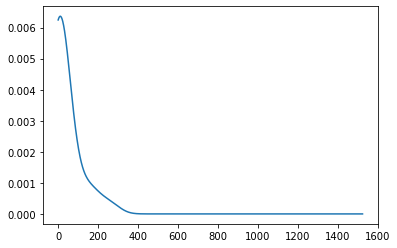

In [89]:
model = UserKNN(k=10)
model.fit(trainset)
_ = model.test(testset)

n_queries = dict()
for alice, secrets in model.known_secrets.items():
    for bob, _ in secrets:
        n_queries[bob] = n_queries.get(bob, 0) + 1

#userknn_scores = np.array(list(model.exposure_u.values()))
userknn_scores = np.array(list(n_queries.values()))
counts, edges = np.histogram(userknn_scores, bins=25)
kde = KernelDensity(bandwidth=50.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
logprob = kde.score_samples(np.linspace(0, np.max(edges), 1000).reshape(-1, 1))
plt.plot(np.linspace(0, np.max(edges), 1000), np.exp(logprob))
threshold = np.linspace(0, np.max(edges), 1000)[np.argmax(np.gradient(np.gradient(np.exp(logprob))))]
threshold

In [86]:
model = UserKNN(k=10, reuse=True, tau_2=0.5)
model.fit(trainset)
_ = model.test(testset)

n_queries = dict()
for alice, secrets in model.known_secrets.items():
    for bob, _ in secrets:
        n_queries[bob] = n_queries.get(bob, 0) + 1

#reuseknn_scores = np.array(list(model.exposure_u.values()))
reuseknn_scores = np.array(list(n_queries.values()))

In [87]:
np.mean(userknn_scores), np.mean(reuseknn_scores)

(208.9257688229056, 264.09785522788206)

In [88]:
userknn_protected_users = dict()
for uid, score in enumerate(userknn_scores):
    if score > threshold:
        userknn_protected_users[uid] = score

reuseknn_protected_users = dict()
for uid, score in enumerate(reuseknn_scores):
    if score > threshold:
        reuseknn_protected_users[uid] = score

len(userknn_protected_users), len(reuseknn_protected_users)

(920, 374)

In [82]:
frac = []
for thresh in range(1, 450):
    f = len(reuseknn_scores[reuseknn_scores > thresh]) / max(len(userknn_scores[userknn_scores > thresh]), 1)
    frac.append(f)

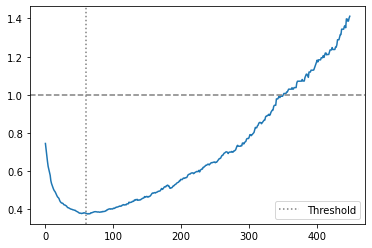

In [84]:
%matplotlib inline
plt.plot(frac)
plt.axhline(y=1, linestyle="dashed", color="gray")
plt.axvline(x=threshold, linestyle="dotted", color="gray", label="Threshold")
plt.legend()